# Quantum kernel vs machine learning classic

## DLP amb ML classic 
Comencem veien com ml classic fa amb el problema del logaritme discret

In [1]:
# Reexecutem després del reset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler, Session
from qiskit_aer import AerSimulator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

import matplotlib.pyplot as plt


In [2]:
def generate_dataset(p, g):
    X = np.arange(1, p)
    log_table = {pow(g, i, p): i for i in range(1, p)}
    X_log = np.array([log_table[x] for x in X])

    s = np.random.randint(0, p - 2)
    r = (p - 3) // 2
    label_range = (s, s + r) if s + r < p - 1 else (s, (s + r) % (p - 1))

    def assign_label(log_val):
        if label_range[0] < label_range[1]:
            return 1 if label_range[0] <= log_val <= label_range[1] else -1
        else:
            return 1 if log_val >= label_range[0] or log_val <= label_range[1] else -1

    y = np.array([assign_label(val) for val in X_log])
    X_reshaped = X.reshape(-1, 1) / p
    return X_reshaped, y

In [67]:
# Reexecutem després del reset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

# ----------------------
# FUNCIONS AUXILIARS
# ----------------------
def generate_dataset(p, g):
    X = np.arange(1, p)
    log_table = {pow(g, i, p): i for i in range(1, p)}
    X_log = np.array([log_table[x] for x in X])

    s = np.random.randint(0, p - 2)
    r = (p - 3) // 2
    label_range = (s, s + r) if s + r < p - 1 else (s, (s + r) % (p - 1))

    def assign_label(log_val):
        if label_range[0] < label_range[1]:
            return 1 if label_range[0] <= log_val <= label_range[1] else -1
        else:
            return 1 if log_val >= label_range[0] or log_val <= label_range[1] else -1

    y = np.array([assign_label(val) for val in X_log])
    X_reshaped = X.reshape(-1, 1) / p
    return X_reshaped, y

# ----------------------
# BUCLE D'ITERACIONS
# ----------------------
p = 199
g = 3
n_iter = 20

best_acc_lr = 0
best_acc_svm = 0

best_model_lr = None
best_model_svm = None

for _ in range(n_iter):
    X, y = generate_dataset(p, g)
    perm = np.random.permutation(len(X))
    X_scrambled = X[perm]
    y_scrambled = y[perm]
    X_train, X_test, y_train, y_test = train_test_split(X_scrambled, y_scrambled, test_size=0.3, random_state=42)

    clf_lr = LogisticRegression().fit(X_train, y_train)
    acc_lr = accuracy_score(y_test, clf_lr.predict(X_test))
    if acc_lr > best_acc_lr:
        best_acc_lr = acc_lr
        best_model_lr = clf_lr
    
    clf_svm = SVC(kernel='rbf').fit(X_train, y_train)
    acc_svm = accuracy_score(y_test, clf_svm.predict(X_test))
    if acc_svm > best_acc_svm:
        best_acc_svm = acc_svm
        best_model_svm = clf_svm

# ----------------------
# RESULTATS FINALS
# ----------------------
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM (RBF kernel)'],
    'Best Accuracy': [best_acc_lr, best_acc_svm]
})

print(results_df)

                 Model  Best Accuracy
0  Logistic Regression       0.633333
1     SVM (RBF kernel)       0.666667


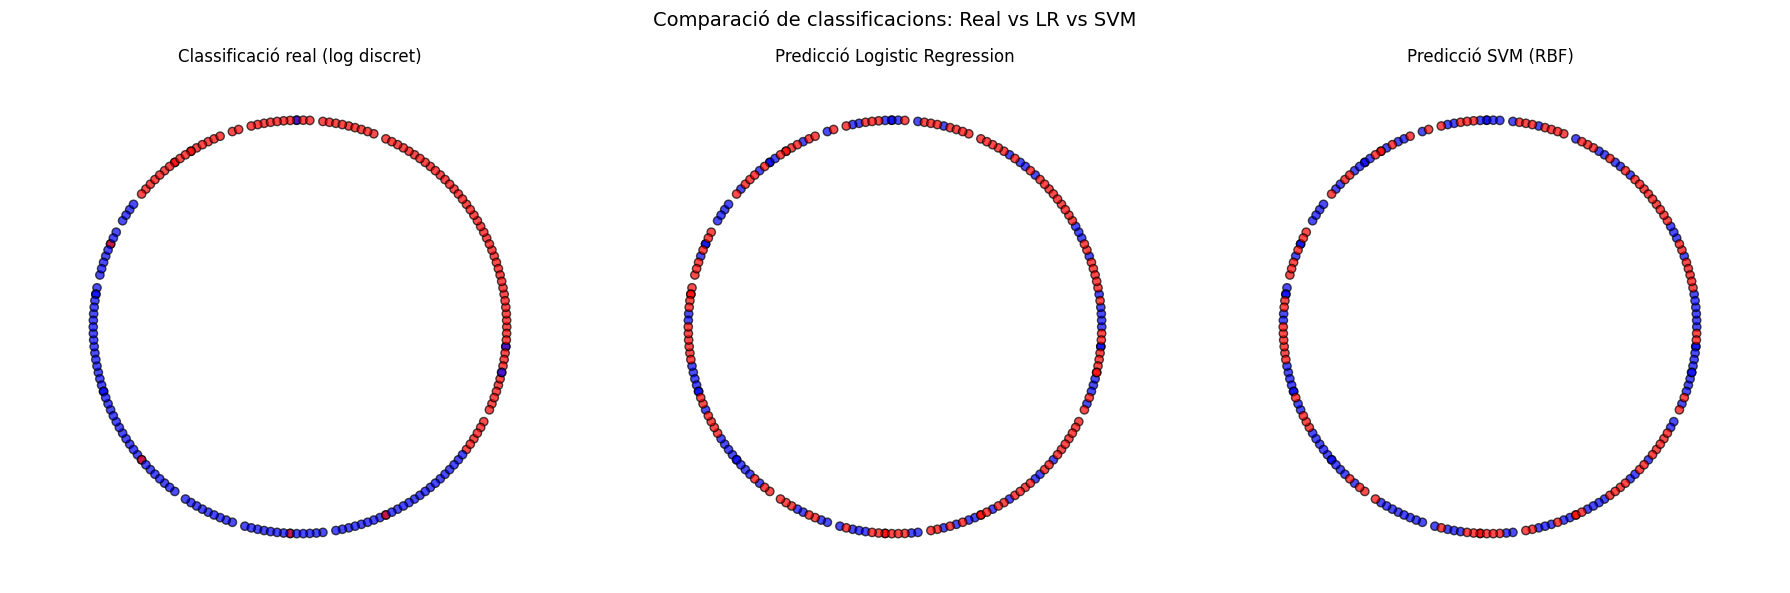

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Reconstruïm les dades originals i el log discret
log_table = {pow(g, i, p): i for i in range(1, p)}
X_original = (X.flatten() * p).astype(int)
X_log = np.array([log_table[x] for x in X_original])

# Angle circular
theta_log = 2 * np.pi * X_log / (p - 1)
x_circle = np.cos(theta_log)
y_circle = np.sin(theta_log)

# Prediccions dels models
y_pred_lr = best_model_lr.predict(X)
y_pred_svm = best_model_svm.predict(X)

# Figures
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# -- Subplot 1: Classificació real
axs[0].scatter(x_circle, y_circle, c=y, cmap='bwr', edgecolor='k', alpha=0.7)
axs[0].set_title("Classificació real (log discret)")
axs[0].axis('equal')
axs[0].axis('off')

# -- Subplot 2: Predicció Logistic Regression (sense marcar errors)
axs[1].scatter(x_circle, y_circle, c=y_pred_lr, cmap='bwr', edgecolor='k', alpha=0.7)
axs[1].set_title("Predicció Logistic Regression")
axs[1].axis('equal')
axs[1].axis('off')

# -- Subplot 3: Predicció SVM (RBF) (sense marcar errors)
axs[2].scatter(x_circle, y_circle, c=y_pred_svm, cmap='bwr', edgecolor='k', alpha=0.7)
axs[2].set_title("Predicció SVM (RBF)")
axs[2].axis('equal')
axs[2].axis('off')

plt.suptitle("Comparació de classificacions: Real vs LR vs SVM", fontsize=14)
plt.savefig("qk_DLP_ml.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [33]:
from sympy import isprime, primerange, is_primitive_root
import matplotlib.pyplot as plt
# Paràmetres i configuració
prime_range = list(primerange(100, 1000))
n_iter_per_p = 30
results_best = []

for p in prime_range:
    g = next((g for g in range(2, p) if is_primitive_root(g, p)), None)
    if g is None:
        continue

    best_acc_lr = 0
    best_acc_svm = 0

    for _ in range(n_iter_per_p):
        X, y = generate_dataset(p, g)
        if X is None:
            break
        perm = np.random.permutation(len(X))
        X_scrambled = X[perm]
        y_scrambled = y[perm]
        X_train, X_test, y_train, y_test = train_test_split(X_scrambled, y_scrambled, test_size=0.3, random_state=42)

        clf_lr = LogisticRegression().fit(X_train, y_train)
        acc_lr = accuracy_score(y_test, clf_lr.predict(X_test))
        best_acc_lr = max(best_acc_lr, acc_lr)

        clf_svm = SVC(kernel='rbf').fit(X_train, y_train)
        acc_svm = accuracy_score(y_test, clf_svm.predict(X_test))
        best_acc_svm = max(best_acc_svm, acc_svm)

    results_best.append((p, best_acc_lr, best_acc_svm))

# Convertim a DataFrame i mostrem
results_df_best = pd.DataFrame(results_best, columns=['Prime p', 'Best LR Accuracy', 'Best SVM Accuracy'])



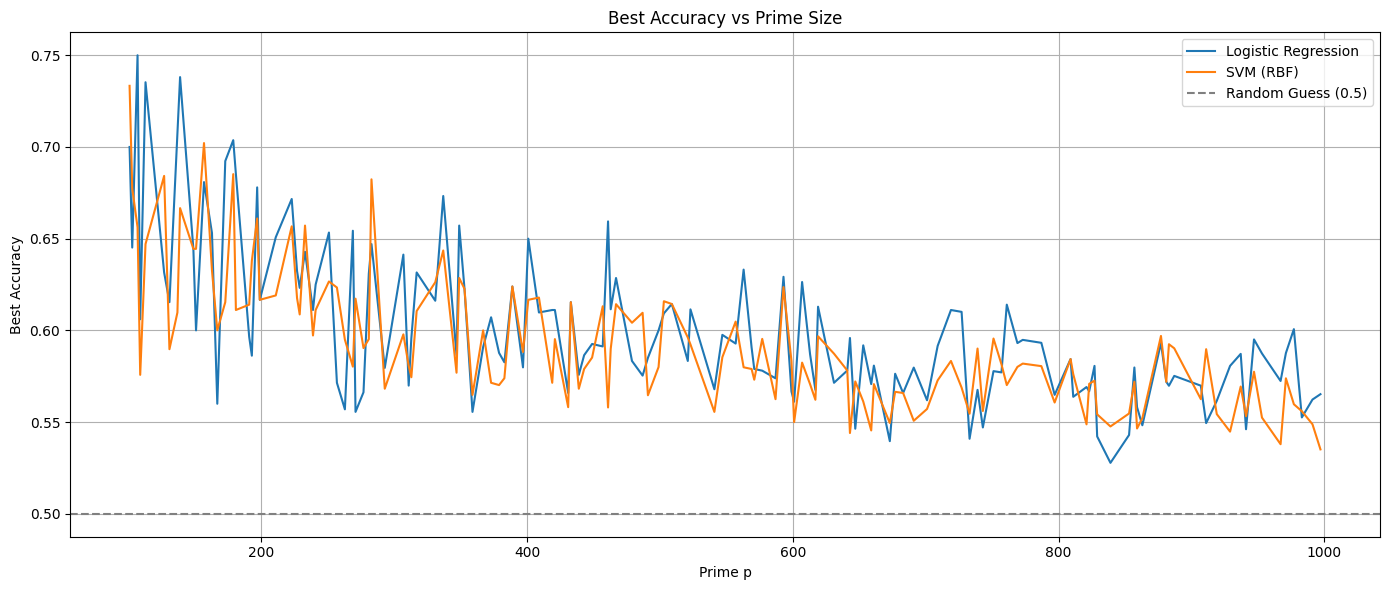

In [36]:
# Gràfic millor format amb línia de referència a y = 0.5 i eix X més allargat
plt.figure(figsize=(14, 6))
plt.plot(results_df_best['Prime p'], results_df_best['Best LR Accuracy'], label='Logistic Regression')
plt.plot(results_df_best['Prime p'], results_df_best['Best SVM Accuracy'], label='SVM (RBF)')
plt.axhline(y=0.5, color='gray', linestyle='--', label='Random Guess (0.5)')
plt.xlabel('Prime p')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy vs Prime Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("qk_DLP_acc_ml.png", dpi=300, bbox_inches='tight')
plt.show()


## DPL amb QML quantum kernel

## 1 qubits Fake backend

In [37]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler, Session
from qiskit_aer import AerSimulator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
 
backend = AerSimulator()
sampler = Sampler(mode=backend, options={"default_shots": 10})
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

# Feature map amb 1 qubit
def custom_feature_map_1qubit(x, theta=np.pi/2):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(-2 * x[0], 0)
    qc.rx(-2 * x[0], 0)
    return qc

# Calcula kernel usant fidelitat entre estats (via circuits conjunts)
def quantum_kernel_matrix(X1, X2, theta=np.pi/2):
    kernel = np.zeros((len(X1), len(X2)))
    circuits = []
    pairs = []

    for i in range(len(X1)):
        for j in range(len(X2)):
            qc = QuantumCircuit(1)
            fm1 = custom_feature_map_1qubit(X1[i], theta)
            fm2 = custom_feature_map_1qubit(X2[j], theta).inverse()
            qc.compose(fm1, inplace=True)
            qc.compose(fm2, inplace=True)
            qc.measure_all()
            transpiled_qc = pass_manager.run(qc)
            circuits.append(transpiled_qc)
            pairs.append((i, j))

    results = sampler.run(circuits).result()
    meas = results[0].data.meas
    counts_list = meas.get_counts()
    if isinstance(counts_list, dict):
        counts_iterable = [counts_list]
    else:
        counts_iterable = counts_list
    for idx, counts in enumerate(counts_iterable):
        total = sum(counts.values())
        fid = counts.get("0", 0) / total if total else 0
    
        i, j = pairs[idx]
        kernel[i, j] = fid

    return kernel

In [55]:
# Dataset i configuració
p = 199
g = 3
# Dataset
X = np.arange(1, p).reshape(-1, 1)
log_table = {pow(g, i, p): i for i in range(1, p)}
X_log = np.array([log_table[x[0]] for x in X])

s = np.random.randint(0, p - 2)
r = (p - 3) // 2
label_range = (s, s + r) if s + r < p - 1 else (s, (s + r) % (p - 1))

def assign_label(v):
    if label_range[0] < label_range[1]:
        return 1 if label_range[0] <= v <= label_range[1] else -1
    else:
        return 1 if v >= label_range[0] or v <= label_range[1] else -1

y = np.array([assign_label(val) for val in X_log])

# Escalat
X_scaled = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X)

# 1 qubit
X_single = X_scaled

# Split
X_train, X_test, y_train, y_test = train_test_split(X_single, y, test_size=0.3, random_state=42)




In [27]:
# Kernel + SVM
K_train = quantum_kernel_matrix(X_train, X_train)
K_test = quantum_kernel_matrix(X_test, X_train)
svm = SVC(kernel='precomputed')
svm.fit(K_train, y_train)
acc = accuracy_score(y_test, svm.predict(K_test))

print(f"Millor accuracy amb Quantum Kernel personalitzat (1 qubit, Aer Simulator): {acc:.4f}")

Millor accuracy amb Quantum Kernel personalitzat (1 qubit, Aer Simulator): 0.4833


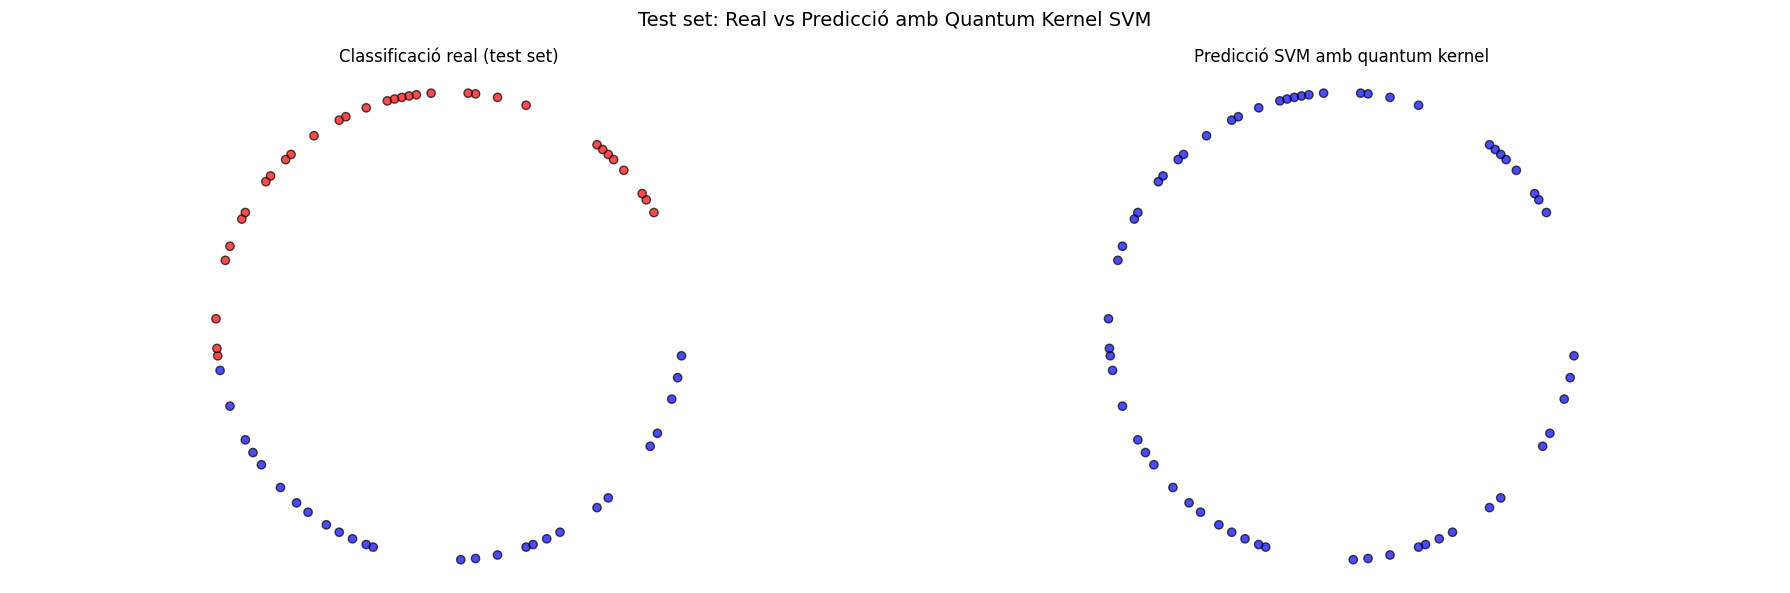

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Primer, tornem a crear l'escalador per poder fer l'invers
scaler = MinMaxScaler(feature_range=(0, np.pi))
scaler.fit(X)  # Fit amb X original

# Inversem la transformació de X_test
X_test_unscaled = scaler.inverse_transform(X_test).flatten().astype(int)

# Apliquem log_table per obtenir el log discret
X_test_log = np.array([log_table[x] for x in X_test_unscaled])

# Angle circular
theta_test = 2 * np.pi * X_test_log / (p - 1)
x_circle_test = np.cos(theta_test)
y_circle_test = np.sin(theta_test)

# Prediccions
y_pred_qk = svm.predict(K_test)

# Figures
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# -- Subplot 1: Classificació real (test set)
axs[0].scatter(x_circle_test, y_circle_test, c=y_test, cmap='bwr', edgecolor='k', alpha=0.7)
axs[0].set_title("Classificació real (test set)")
axs[0].axis('equal')
axs[0].axis('off')

# -- Subplot 2: Predicció Quantum Kernel SVM (test set)
axs[1].scatter(x_circle_test, y_circle_test, c=y_pred_qk, cmap='bwr', edgecolor='k', alpha=0.7)
axs[1].set_title("Predicció SVM amb quantum kernel")
axs[1].axis('equal')
axs[1].axis('off')

plt.suptitle("Test set: Real vs Predicció amb Quantum Kernel SVM amb 1 qubit", fontsize=14)
plt.tight_layout()
plt.savefig("qk_DLP_qml_1q_testset.png", dpi=300, bbox_inches='tight')
plt.show()


In [40]:
from qiskit import QuantumCircuit
import numpy as np

def custom_feature_map_nqubits(x, n_qubits, reps=2):
    qc = QuantumCircuit(n_qubits)

    for _ in range(reps):
        # Aplicació de rotacions no trivials
        for i in range(n_qubits):
            angle = x[i % len(x)]
            qc.ry(angle, i)

    return qc

def quantum_kernel_matrix(X1, X2, pass_manager, sampler, n_qubits):
    kernel = np.zeros((len(X1), len(X2)))
    circuits = []
    pairs = []

    for i in range(len(X1)):
        for j in range(len(X2)):
            qc = QuantumCircuit(n_qubits)
            fm_x = custom_feature_map_nqubits(X1[i], n_qubits)
            fm_xp_inv = custom_feature_map_nqubits(X2[j], n_qubits).inverse()

            # Compose feature map and its inverse
            qc.compose(fm_x, inplace=True)
            qc.compose(fm_xp_inv, inplace=True)

            qc.measure_all()

            transpiled = pass_manager.run(qc)
            circuits.append(transpiled)
            pairs.append((i, j))

    # Run all circuits in batch
    result = sampler.run(circuits).result()
    meas = result[0].data.meas
    counts_list = meas.get_counts()
    if isinstance(counts_list, dict):
        counts_iterable = [counts_list]
    else:
        counts_iterable = counts_list

    for idx, counts in enumerate(counts_iterable):
        total = sum(counts.values())
        fid = counts.get('0' * n_qubits, 0) / total if total else 0
        i, j = pairs[idx]
        kernel[i, j] = fid

    return kernel


In [41]:
X_raw, y = generate_dataset(p=199, g=3)
X_expanded = np.hstack([X_raw, X_raw**2, np.sin(2 * np.pi * X_raw)])
# Guardem X_raw original abans de fer el split
X_raw_train, X_raw_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)
X_train, X_test = train_test_split(X_expanded, test_size=0.3, random_state=42)


backend = AerSimulator()
sampler = Sampler(mode=backend, options={"default_shots": 1})
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

n_qubits = 3
K_train = quantum_kernel_matrix(X_train, X_train, pass_manager, sampler, n_qubits)
K_test = quantum_kernel_matrix(X_test, X_train, pass_manager, sampler, n_qubits)

svm = SVC(kernel='precomputed')
svm.fit(K_train, y_train)
y_pred_qk = svm.predict(K_test)

acc = accuracy_score(y_test, y_pred_qk)
print(f"Accuracy amb custom {n_qubits}-qubit feature map: {acc:.4f}")

Accuracy amb custom 3-qubit feature map: 0.4833


In [39]:
print(y_pred_qk)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


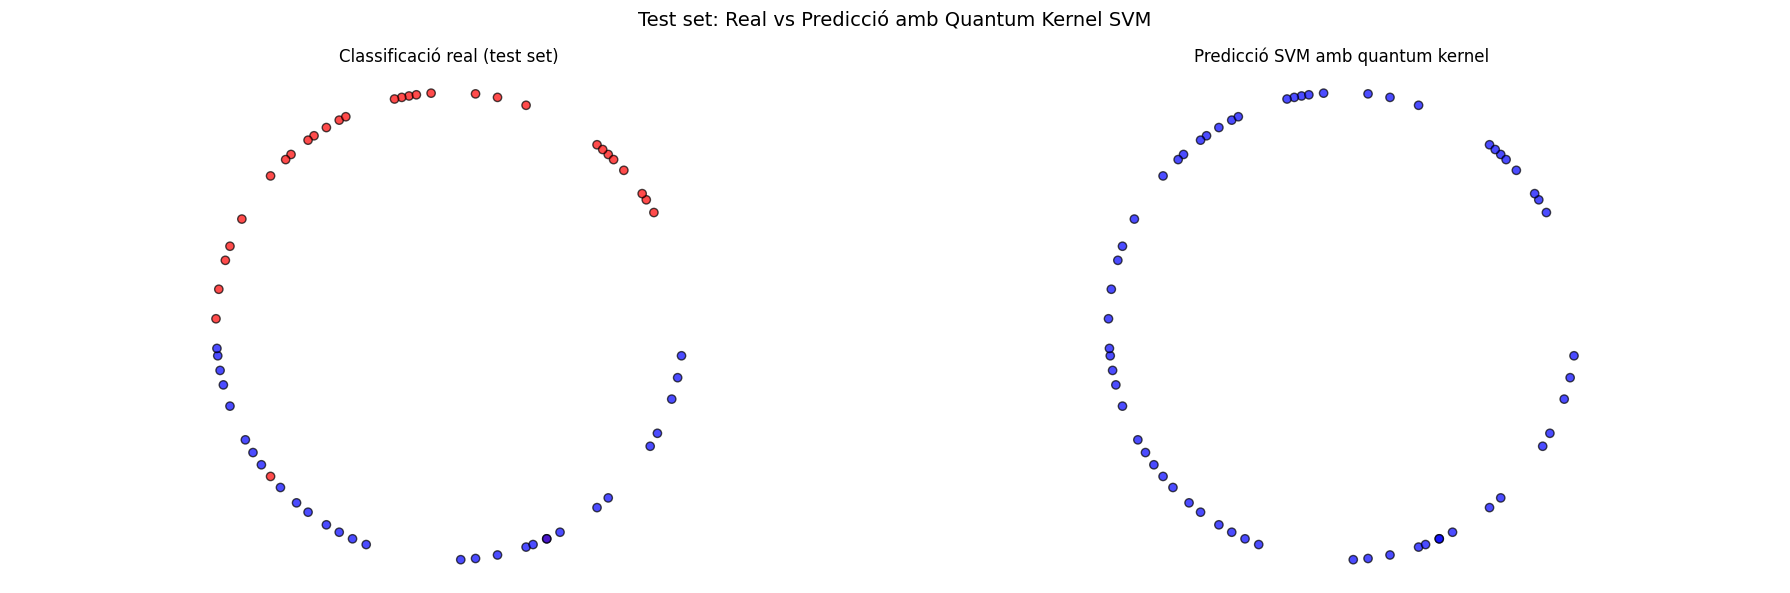

In [42]:
import matplotlib.pyplot as plt

p = 199
g = 3
log_table = {pow(g, i, p): i for i in range(1, p)}
X_test_integers = (X_raw_test.flatten() * p).astype(int)
X_test_log = np.array([log_table[x] for x in X_test_integers])

theta_test = 2 * np.pi * X_test_log / (p - 1)
x_circle_test = np.cos(theta_test)
y_circle_test = np.sin(theta_test)

# Gràfics
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].scatter(x_circle_test, y_circle_test, c=y_test, cmap='bwr', edgecolor='k', alpha=0.7)
axs[0].set_title("Classificació real (test set)")
axs[0].axis('equal')
axs[0].axis('off')

axs[1].scatter(x_circle_test, y_circle_test, c=y_pred_qk, cmap='bwr', edgecolor='k', alpha=0.7)
axs[1].set_title("Predicció SVM amb quantum kernel")
axs[1].axis('equal')
axs[1].axis('off')

plt.suptitle("Test set: Real vs Predicció amb Quantum Kernel SVM amb 3 qubits", fontsize=14)
plt.tight_layout()
plt.savefig("qk_DLP_qml_2q_testset.png", dpi=300, bbox_inches='tight')
plt.show()


## Ara fer amb 1qubits amb backend real

In [86]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_cloud',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/8cece2f5b77849faae3733c972693084:d12a9c47-0ec5-442d-a695-cbdaf07d3cb9::'
)
job = service.job('d0vcbfg7m9ds739j394g')
job_result = job.result()
job_result[0].data.meas

BitArray(<shape=(), num_shots=10, num_bits=1>)

In [87]:
dir(job_result[0].data.meas)

['__abstractmethods__',
 '__and__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__non_callable_proto_members__',
 '__or__',
 '__parameters__',
 '__protocol_attrs__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '__xor__',
 '_abc_impl',
 '_array',
 '_bytes_to_bitstring',
 '_bytes_to_int',
 '_get_counts',
 '_is_protocol',
 '_is_runtime_protocol',
 '_num_bits',
 '_prepare_broadcastable',
 '_shape',
 'array',
 'bitcount',
 'concatenate',
 'concatenate_bits',
 'concatenate_shots',
 'expectation_values',
 'from_bool_array',
 'from_counts',
 'from_samples',
 'get_bitstrings',
 'get_counts',
 'get_int_counts',
 '

In [109]:
X1 = X_train 
X2 = X_train
kernel = np.zeros((len(X1), len(X2)))
counts_list = job_result[0].data.meas.get_counts()
counts_list

{'0': 10}

In [111]:
# Posem tot en una llista si només tenim un diccionari
if isinstance(counts_list, dict):
    counts_iterable = [counts_list]
else:
    counts_iterable = counts_list
for idx, counts in enumerate(counts_iterable):
    total = sum(counts.values())
    fid = counts.get("0", 0) / total if total else 0

    i, j = pairs[idx]
    kernel[i, j] = fid

kernel

[{'0': 10}]


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler, Session
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
sampler = Sampler(mode=backend, options={"default_shots": 10})
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)